In [1]:
import numpy as np
from sunbird.inference.pocomc import PocoMCSampler
from sunbird.inference.emcee import EmceeSampler

from sunbird.inference.priors import Yuan23, AbacusSummit
from acm.compression.cca import compute_cca_compression, apply_compression
import argparse
from acm.data.io_tools import *
from sunbird import setup_logging

In [2]:
%load_ext autoreload
%autoreload 2

# inline matplotlib
%matplotlib inline

In [3]:
def get_covariance_correction(n_s, n_d, n_theta=None, correction_method='percival'):
    if correction_method == 'percival':
        B = (n_s - n_d - 2) / ((n_s - n_d - 1)*(n_s - n_d - 4))
        return (n_s - 1)*(1 + B*(n_d - n_theta))/(n_s - n_d + n_theta - 1)
    elif correction_method == 'hartlap':
        return (n_s - 1)/(n_s - n_d - 2)


def get_priors(cosmo=True, hod=True):
    stats_module = 'scipy.stats'
    priors, ranges, labels = {}, {}, {}
    if cosmo:
        priors.update(AbacusSummit(stats_module).priors)
        ranges.update(AbacusSummit(stats_module).ranges)
        labels.update(AbacusSummit(stats_module).labels)
    if hod:
        priors.update(Yuan23(stats_module).priors)
        ranges.update(Yuan23(stats_module).ranges)
        labels.update(Yuan23(stats_module).labels)
    return priors, ranges, labels


In [17]:
statistic = 'pk'
cosmo_idx = 0
hod_idx = 30

In [18]:
priors, ranges, labels = get_priors(cosmo=True, hod=True)
select_filters = {'cosmo_idx': cosmo_idx, 'hod_idx': hod_idx,}

In [19]:
fixed_params = ['w0_fld', 'wa_fld', 'N_ur', 'nrun']
add_emulator_error = True
statistics = [statistic]

slice_filters = {}
covariance_matrix, n_sim = read_covariance(statistics=statistics,
                                            select_filters=select_filters,
                                            slice_filters=slice_filters)

In [20]:
data_x, data_y, data_x_names, model_filters = read_lhc(statistics=statistics,
                                                    select_filters=select_filters,
                                                    slice_filters=slice_filters,
                                                    return_mask=True)

In [30]:
# Need to read all parameters and data!
lhc_x, lhc_y, coords = read_lhc(statistics=[statistic],
                                    select_filters=None,#{'hod_idx': 0,},
                                    slice_filters=slice_filters)

In [31]:
lhc_x = lhc_x.reshape((-1, data_x.shape[-1]))
lhc_y = lhc_y.reshape((-1, data_y.shape[-1]))

In [32]:
import scipy 



def compute_cca_compression_np(data, params,):
    #data_mean = np.mean(data, axis=0)
    #param_mean = np.mean(params, axis=0)
    #data_centered = data - data_mean
    #param_centered = params - param_mean
    cov_all = np.cov(params.T, data.T)
    n_params = params.shape[1]
    Cp = cov_all[:n_params, :n_params]
    Ct = cov_all[n_params:, n_params:]
    Cpt = cov_all[:n_params, n_params:]

    # Projected covariance
    Cl = Cpt.T @ np.linalg.inv(Cp) @ Cpt
    
    # Standard eigenvalue problem
    diff = Ct - Cl 
    
    # Use scipy's eigh for symmetric matrices
    eigenvals, eigenvecs = scipy.linalg.eigh(a=Ct, b=diff)
    
    # Sort in descending order
    idx = np.argsort(eigenvals)[::-1]
    
    return eigenvecs[:, idx], eigenvals[idx]

In [33]:
fixed_params = {key: data_x[data_x_names.index(key)]
                    for key in fixed_params}

In [34]:
models = read_model(statistics=statistics)
nn_model = [model.to_jax()[0] for model in models]
nn_params = [model.to_jax()[1] for model in models]

In [35]:

if add_emulator_error:
    emulator_error = read_emulator_error(statistics, select_filters=select_filters,
                                        slice_filters=slice_filters)
    print(f'Loaded emulator error with shape: {emulator_error.shape}')
    covariance_matrix += np.diag(emulator_error**2)


Loaded emulator error with shape: (78,)


In [36]:
# apply correction to the covariance matrix
correction = get_covariance_correction(
    n_s=n_sim,
    n_d=len(covariance_matrix),
    n_theta=len(data_x_names) - len(fixed_params),
    correction_method='percival',
)

In [37]:
print(f'Number of simulations: {n_sim}')
print(f'Number of data points: {len(covariance_matrix)}')
print(f'Number of parameters: {len(data_x_names) - len(fixed_params)}')
print(f'Covariance correction factor: {correction}')
covariance_matrix *= correction
precision_matrix = np.linalg.inv(covariance_matrix)

Number of simulations: 1786
Number of data points: 78
Number of parameters: 16
Covariance correction factor: 1.0736559115146016


In [38]:


noise_samples = np.random.multivariate_normal(
    mean=np.zeros(lhc_y.shape[-1]), 
    cov=covariance_matrix, 
    size=len(lhc_y),
)
noisy_lhc_y = lhc_y + noise_samples
compression_matrix, eigenvals = compute_cca_compression_np(
    data=noisy_lhc_y, 
    params=lhc_x,
)
print(eigenvals)

[4.19615638 3.62222734 2.34808914 1.93440826 1.81386171 1.64046121
 1.30050501 1.23332595 1.18875956 1.130326   1.06655209 1.06472234
 1.04926154 1.0465786  1.02801144 1.02464427 1.01644419 1.01131757
 1.00637477 1.0023059  1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]


In [39]:
lhc_x.shape

(21250, 20)

In [40]:
# Compute compressed data vector + compressed covariance matrix
n_components = lhc_x.shape[-1]
compressed_data = data_y @ compression_matrix[:, :n_components]

In [41]:
compressed_covariance = compression_matrix[:, :n_components].T @ covariance_matrix @ compression_matrix[:, :n_components]

In [42]:
compressed_lhc_y = lhc_y @ compression_matrix[:, :n_components]

<ErrorbarContainer object of 3 artists>

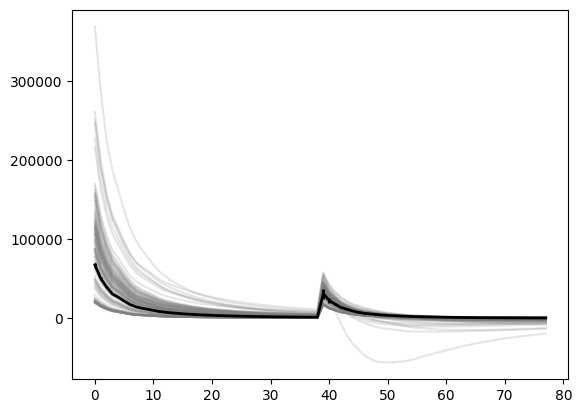

In [43]:
import matplotlib.pyplot as plt
for i in range(100):
    plt.plot(lhc_y[i], alpha=0.2, color='gray')
plt.errorbar(
    range(len(data_y)),
    data_y,
    yerr=np.sqrt(np.diag(covariance_matrix)),
    color='black',
    linewidth=2,
)

<ErrorbarContainer object of 3 artists>

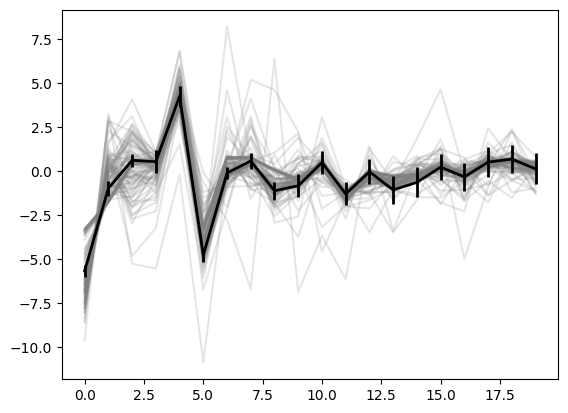

In [44]:
for i in range(100):
    plt.plot(compressed_lhc_y[i], alpha=0.2, color='gray')
plt.errorbar(
    range(len(compressed_data)),
    compressed_data,
    yerr=np.sqrt(np.diag(compressed_covariance)),
    color='black',
    linewidth=2,
)

<ErrorbarContainer object of 3 artists>

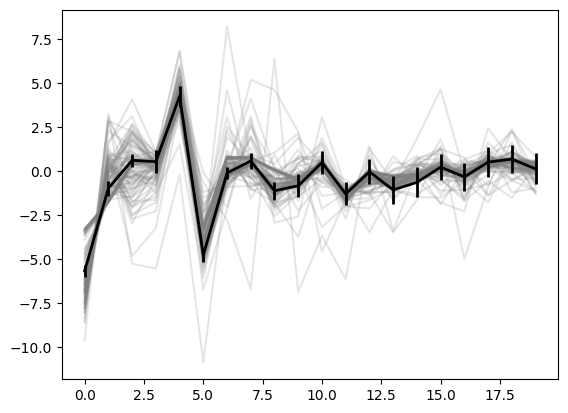

In [45]:
for i in range(100):
    plt.plot(compressed_lhc_y[i], alpha=0.2, color='gray')
plt.errorbar(
    range(len(compressed_data)),
    compressed_data,
    yerr=np.sqrt(np.diag(compressed_covariance)),
    color='black',
    linewidth=2,
)

In [46]:
models[0].to('cpu')

FCN(
  (mlp): Sequential(
    (mlp0): Linear(in_features=20, out_features=936, bias=True)
    (act0): LearnedSigmoid()
    (dropout0): Dropout(p=0.0005478283101577841, inplace=False)
    (mlp1): Linear(in_features=936, out_features=936, bias=True)
    (act1): LearnedSigmoid()
    (dropout1): Dropout(p=0.0005478283101577841, inplace=False)
    (mlp2): Linear(in_features=936, out_features=936, bias=True)
    (act2): LearnedSigmoid()
    (dropout2): Dropout(p=0.0005478283101577841, inplace=False)
    (mlp3): Linear(in_features=936, out_features=936, bias=True)
    (act3): LearnedSigmoid()
    (dropout3): Dropout(p=0.0005478283101577841, inplace=False)
    (mlp4): Linear(in_features=936, out_features=78, bias=True)
  )
  (loss_fct): L1Loss()
)

In [19]:
sampler = EmceeSampler(
    observation=data_y,
    precision_matrix=precision_matrix,
    theory_model=models,
    fixed_parameters=fixed_params,
    priors=priors,
    ranges=ranges,
    labels=labels,
    model_filters=model_filters,
)
sampler(nwalkers=32, niter=1_000, nthreads=1, vectorize=True, burnin=50)


LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

In [16]:
sampler.triangle_plot(save_fn='emcee_triangle.pdf', thin=128,
                      params=['omega_cdm', 'sigma8_m', 'n_s'],
                      markers={'omega_cdm': 0.12, 'sigma8_m': 0.807952, 'n_s': 0.9649})

TypeError: tuple indices must be integers or slices, not str